# Word2Vec Scratch

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from collections import defaultdict
import multiprocessing

import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from preprocessing_funcs import clean_tweet, get_hashtags, hashtag_dict

TEST

In [2]:
documents = ["Will this work?  I'm not sure.  If not go to step #4 (above)"]
texts = [[word for word in document.lower().split()]
         for document in documents]


print (texts)
model = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1, workers=2,sg=1)

[['will', 'this', 'work?', "i'm", 'not', 'sure.', 'if', 'not', 'go', 'to', 'step', '#4', '(above)']]


## Data Import

In [3]:
with open('../data_files/processed_tweets.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [4]:
df.head()

,clean,processed
0,islam kills are you trying to say that there w...,islam kill try say terrorist attack europe ref...
1,clinton trump should ve apologized more attack...,clinton trump apologize attack little
2,who was is the best president of the past year...,well president past retweet
3,i don t have to guess your religion christmasa...,guess religion christmasaftermath
4,pence and his lawyers decided which of his off...,pence lawyer decide official email public can see


# Modeling

Following the steps laid out in this [SUPER GREAT TUTORIAL](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial)

In [5]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## Hunting for bigrams

In [6]:
sent = [row.split() for row in df['clean']]

In [7]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 12:36:03: collecting all words and their counts
INFO - 12:36:03: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 12:36:03: PROGRESS: at sentence #10000, processed 123141 words and 92858 word types
INFO - 12:36:03: PROGRESS: at sentence #20000, processed 247649 words and 160911 word types
INFO - 12:36:03: PROGRESS: at sentence #30000, processed 371430 words and 219454 word types
INFO - 12:36:04: PROGRESS: at sentence #40000, processed 493933 words and 271905 word types
INFO - 12:36:04: PROGRESS: at sentence #50000, processed 616155 words and 320365 word types
INFO - 12:36:04: PROGRESS: at sentence #60000, processed 739920 words and 365739 word types
INFO - 12:36:04: PROGRESS: at sentence #70000, processed 863038 words and 408886 word types
INFO - 12:36:04: PROGRESS: at sentence #80000, processed 986803 words and 450522 word types
INFO - 12:36:05: PROGRESS: at sentence #90000, processed 1109759 words and 489765 word types
INFO - 12:36:05: PROGRESS: at sentence 

In [8]:
bigram = Phraser(phrases)

INFO - 12:36:09: source_vocab length 852863
INFO - 12:36:15: Phraser built with 1018 phrasegrams


In [9]:
sentences = bigram[sent]

## Most frequent words

In [10]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

92656

In [11]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['the', 'to', 'a', 'in', 'trump', 's', 'of', 'is', 'and', 'for']

## Training the model

### Initialize Model

In [12]:
cores = multiprocessing.cpu_count()
cores

12

In [13]:
w2v_model = Word2Vec(min_count=20,
                     window=8,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=15,
                     workers=cores-1)

### Build Vocabulary

In [14]:
from time import time 

In [15]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 12:36:38: collecting all words and their counts
INFO - 12:36:38: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 12:36:38: PROGRESS: at sentence #10000, processed 115694 words, keeping 18677 word types
INFO - 12:36:39: PROGRESS: at sentence #20000, processed 232842 words, keeping 27600 word types
INFO - 12:36:39: PROGRESS: at sentence #30000, processed 349077 words, keeping 34446 word types
INFO - 12:36:39: PROGRESS: at sentence #40000, processed 464287 words, keeping 40083 word types
INFO - 12:36:39: PROGRESS: at sentence #50000, processed 579189 words, keeping 45159 word types
INFO - 12:36:40: PROGRESS: at sentence #60000, processed 695398 words, keeping 49671 word types
INFO - 12:36:40: PROGRESS: at sentence #70000, processed 810960 words, keeping 53877 word types
INFO - 12:36:40: PROGRESS: at sentence #80000, processed 927325 words, keeping 57809 word types
INFO - 12:36:40: PROGRESS: at sentence #90000, processed 1042805 words, keeping 61465 word typ

Time to build vocab: 0.11 mins


### Training of the Model

In [16]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 12:36:50: training model with 11 workers on 9753 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=15 window=8
INFO - 12:36:51: EPOCH 1 - PROGRESS: at 14.35% examples, 153434 words/s, in_qsize 0, out_qsize 0
INFO - 12:36:52: EPOCH 1 - PROGRESS: at 28.81% examples, 154325 words/s, in_qsize 0, out_qsize 0
INFO - 12:36:53: EPOCH 1 - PROGRESS: at 44.51% examples, 157975 words/s, in_qsize 0, out_qsize 0
INFO - 12:36:54: EPOCH 1 - PROGRESS: at 59.34% examples, 157516 words/s, in_qsize 0, out_qsize 0
INFO - 12:36:55: EPOCH 1 - PROGRESS: at 71.64% examples, 152055 words/s, in_qsize 0, out_qsize 0
INFO - 12:36:56: EPOCH 1 - PROGRESS: at 87.31% examples, 154664 words/s, in_qsize 0, out_qsize 0
INFO - 12:36:57: worker thread finished; awaiting finish of 10 more threads
INFO - 12:36:57: worker thread finished; awaiting finish of 9 more threads
INFO - 12:36:57: worker thread finished; awaiting finish of 8 more threads
INFO - 12:36:57: worker thread finished; awaiting finish 

INFO - 12:37:29: EPOCH 6 - PROGRESS: at 94.06% examples, 165765 words/s, in_qsize 0, out_qsize 0
INFO - 12:37:29: worker thread finished; awaiting finish of 10 more threads
INFO - 12:37:29: worker thread finished; awaiting finish of 9 more threads
INFO - 12:37:29: worker thread finished; awaiting finish of 8 more threads
INFO - 12:37:29: worker thread finished; awaiting finish of 7 more threads
INFO - 12:37:29: worker thread finished; awaiting finish of 6 more threads
INFO - 12:37:29: worker thread finished; awaiting finish of 5 more threads
INFO - 12:37:29: worker thread finished; awaiting finish of 4 more threads
INFO - 12:37:29: worker thread finished; awaiting finish of 3 more threads
INFO - 12:37:29: worker thread finished; awaiting finish of 2 more threads
INFO - 12:37:29: worker thread finished; awaiting finish of 1 more threads
INFO - 12:37:29: worker thread finished; awaiting finish of 0 more threads
INFO - 12:37:29: EPOCH - 6 : training on 2358904 raw words (1078093 effective

INFO - 12:38:02: worker thread finished; awaiting finish of 5 more threads
INFO - 12:38:02: worker thread finished; awaiting finish of 4 more threads
INFO - 12:38:02: worker thread finished; awaiting finish of 3 more threads
INFO - 12:38:02: worker thread finished; awaiting finish of 2 more threads
INFO - 12:38:02: worker thread finished; awaiting finish of 1 more threads
INFO - 12:38:02: worker thread finished; awaiting finish of 0 more threads
INFO - 12:38:02: EPOCH - 11 : training on 2358904 raw words (1076703 effective words) took 7.2s, 148846 effective words/s
INFO - 12:38:03: EPOCH 12 - PROGRESS: at 15.19% examples, 162816 words/s, in_qsize 0, out_qsize 0
INFO - 12:38:04: EPOCH 12 - PROGRESS: at 31.79% examples, 167787 words/s, in_qsize 0, out_qsize 0
INFO - 12:38:05: EPOCH 12 - PROGRESS: at 44.09% examples, 154896 words/s, in_qsize 0, out_qsize 0
INFO - 12:38:06: EPOCH 12 - PROGRESS: at 61.03% examples, 161420 words/s, in_qsize 0, out_qsize 0
INFO - 12:38:07: EPOCH 12 - PROGRESS

INFO - 12:38:37: worker thread finished; awaiting finish of 0 more threads
INFO - 12:38:37: EPOCH - 16 : training on 2358904 raw words (1077595 effective words) took 7.2s, 149674 effective words/s
INFO - 12:38:38: EPOCH 17 - PROGRESS: at 13.92% examples, 147541 words/s, in_qsize 0, out_qsize 0
INFO - 12:38:39: EPOCH 17 - PROGRESS: at 27.96% examples, 148766 words/s, in_qsize 0, out_qsize 0
INFO - 12:38:40: EPOCH 17 - PROGRESS: at 39.83% examples, 139971 words/s, in_qsize 0, out_qsize 0
INFO - 12:38:41: EPOCH 17 - PROGRESS: at 52.99% examples, 139689 words/s, in_qsize 0, out_qsize 0
INFO - 12:38:42: EPOCH 17 - PROGRESS: at 67.39% examples, 142070 words/s, in_qsize 0, out_qsize 0
INFO - 12:38:43: EPOCH 17 - PROGRESS: at 82.67% examples, 145635 words/s, in_qsize 0, out_qsize 0
INFO - 12:38:44: EPOCH 17 - PROGRESS: at 97.47% examples, 147183 words/s, in_qsize 0, out_qsize 0
INFO - 12:38:44: worker thread finished; awaiting finish of 10 more threads
INFO - 12:38:44: worker thread finished; 

INFO - 12:39:16: EPOCH 22 - PROGRESS: at 57.22% examples, 151570 words/s, in_qsize 0, out_qsize 0
INFO - 12:39:17: EPOCH 22 - PROGRESS: at 68.23% examples, 144808 words/s, in_qsize 0, out_qsize 0
INFO - 12:39:18: EPOCH 22 - PROGRESS: at 83.09% examples, 146834 words/s, in_qsize 0, out_qsize 0
INFO - 12:39:19: EPOCH 22 - PROGRESS: at 97.88% examples, 148456 words/s, in_qsize 0, out_qsize 0
INFO - 12:39:19: worker thread finished; awaiting finish of 10 more threads
INFO - 12:39:19: worker thread finished; awaiting finish of 9 more threads
INFO - 12:39:19: worker thread finished; awaiting finish of 8 more threads
INFO - 12:39:19: worker thread finished; awaiting finish of 7 more threads
INFO - 12:39:19: worker thread finished; awaiting finish of 6 more threads
INFO - 12:39:19: worker thread finished; awaiting finish of 5 more threads
INFO - 12:39:19: worker thread finished; awaiting finish of 4 more threads
INFO - 12:39:19: worker thread finished; awaiting finish of 3 more threads
INFO - 

INFO - 12:39:53: worker thread finished; awaiting finish of 8 more threads
INFO - 12:39:53: worker thread finished; awaiting finish of 7 more threads
INFO - 12:39:53: worker thread finished; awaiting finish of 6 more threads
INFO - 12:39:53: worker thread finished; awaiting finish of 5 more threads
INFO - 12:39:53: worker thread finished; awaiting finish of 4 more threads
INFO - 12:39:53: worker thread finished; awaiting finish of 3 more threads
INFO - 12:39:53: worker thread finished; awaiting finish of 2 more threads
INFO - 12:39:53: worker thread finished; awaiting finish of 1 more threads
INFO - 12:39:53: worker thread finished; awaiting finish of 0 more threads
INFO - 12:39:53: EPOCH - 27 : training on 2358904 raw words (1077208 effective words) took 6.6s, 163484 effective words/s
INFO - 12:39:54: EPOCH 28 - PROGRESS: at 15.61% examples, 165868 words/s, in_qsize 0, out_qsize 0
INFO - 12:39:55: EPOCH 28 - PROGRESS: at 27.96% examples, 147739 words/s, in_qsize 0, out_qsize 1
INFO - 

Time to train the model: 3.39 mins


## Testing the model

In [17]:
w2v_model.wv.most_similar(positive=["trump"], topn=15)

INFO - 12:40:19: precomputing L2-norms of word weight vectors


[('donald_trump', 0.6407557725906372),
 ('real_donald', 0.5144604444503784),
 ('hillary', 0.47079670429229736),
 ('clinton', 0.45015043020248413),
 ('hillary_clinton', 0.4447818994522095),
 ('maga', 0.44214871525764465),
 ('obama', 0.4290294647216797),
 ('trumptrain_maga', 0.4161383807659149),
 ('president', 0.4054153263568878),
 ('gop', 0.3963947892189026),
 ('pence', 0.3914209008216858),
 ('seanspicer', 0.3907885253429413),
 ('thehill', 0.38342010974884033),
 ('evan_mcmullin', 0.3791126310825348),
 ('politics_extra', 0.3785969614982605)]

In [18]:
w2v_model.wv.most_similar(positive=["clinton"], topn=15)

[('hillary_clinton', 0.6831471920013428),
 ('hillary', 0.6540529727935791),
 ('clinton_camp', 0.5303007960319519),
 ('email_investigation', 0.4852040708065033),
 ('emails_show', 0.48312950134277344),
 ('dnc', 0.47216492891311646),
 ('huma_abedin', 0.4515190124511719),
 ('trump', 0.45015043020248413),
 ('wikileaks_emails', 0.44442152976989746),
 ('politics_extra', 0.44089674949645996),
 ('politics', 0.43945229053497314),
 ('wikileaks', 0.43760383129119873),
 ('email_scandal', 0.4368593096733093),
 ('policticalnews', 0.4344191551208496),
 ('guccifer', 0.4308326542377472)]

In [19]:
w2v_model.wv.doesnt_match(['trump', 'clinton', 'pork', 'thanksgiving' 'emails'])

WARNING - 12:40:31: vectors for words {'thanksgivingemails'} are not present in the model, ignoring these words
/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'pork'

In [20]:
w2v_model.wv.most_similar(positive=["man", "clinton"], negative=["trump"], topn=3)

[('unarmed', 0.3917193114757538),
 ('woman', 0.37511396408081055),
 ('fatal', 0.3715324401855469)]

In [21]:
w2v_model.wv.most_similar(positive=["woman", "obama"], negative=["man"], topn=3)

[('hillary', 0.3723071813583374),
 ('trump', 0.3648530840873718),
 ('hillary_clinton', 0.3488660454750061)]

## Visualizations

In [22]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')  # This relates to the size parameter of the model tuning
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 19 dimensions with PCA 
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

### 10 Most Similar Words vs. 8 Random Words

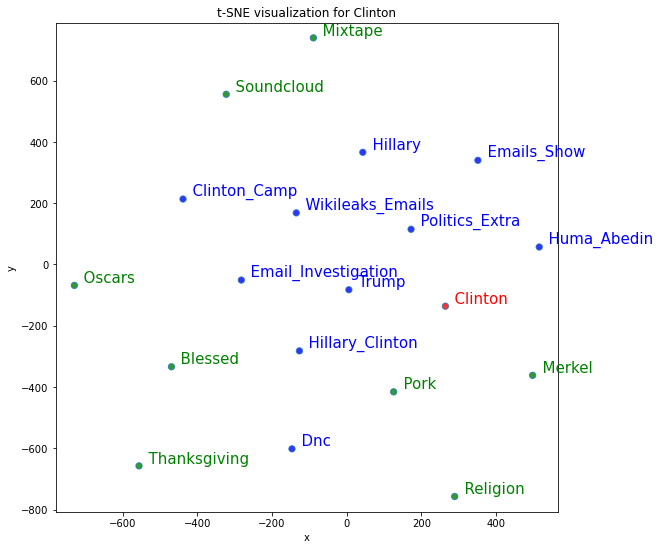

In [23]:
tsnescatterplot(w2v_model, 'clinton', ['soundcloud', 'mixtape', 'merkel', 'blessed', 
                                       'pork', 'thanksgiving', 'oscars', 'religion'])

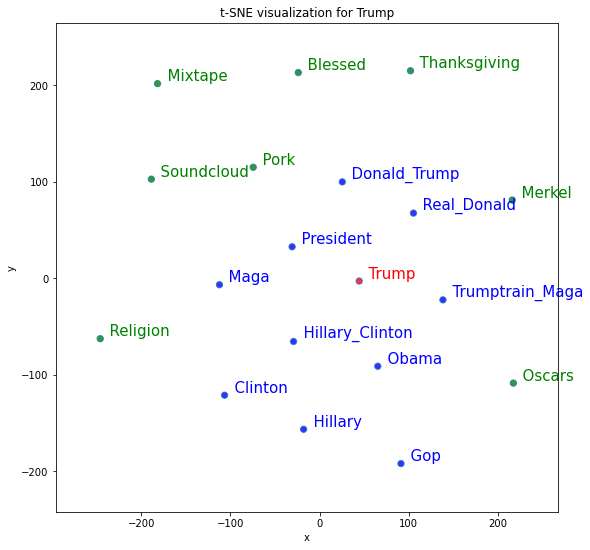

In [24]:
tsnescatterplot(w2v_model, 'trump', ['soundcloud', 'mixtape', 'merkel', 'blessed', 
                                       'pork', 'thanksgiving', 'oscars', 'religion'])

### 10 Most Similar Words vs. 10 Most Dissimilar

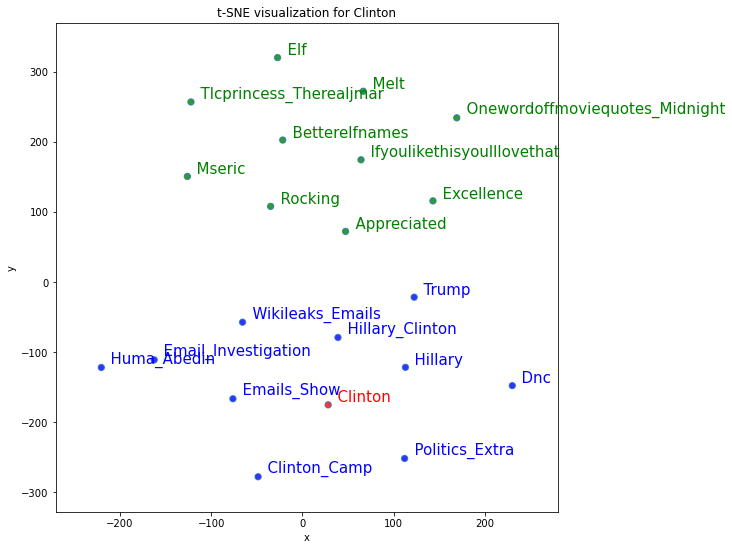

In [25]:
tsnescatterplot(w2v_model, 'clinton', [i[0] for i in w2v_model.wv.most_similar(negative=["clinton"])])

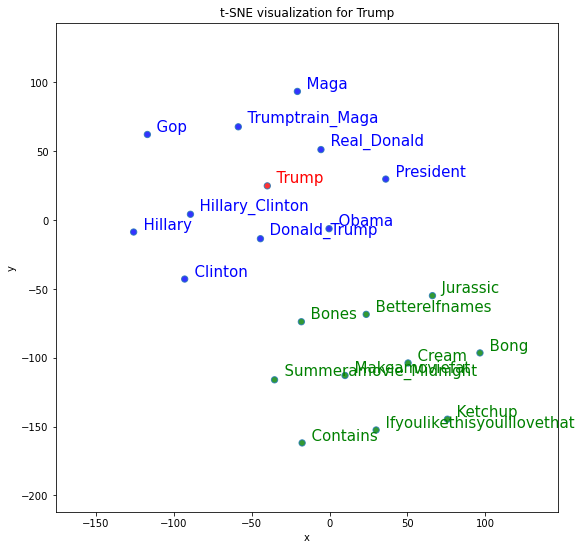

In [26]:
tsnescatterplot(w2v_model, 'trump', [i[0] for i in w2v_model.wv.most_similar(negative=["trump"])])

### 10 Most similar words vs. 11th to 20th Most similar words

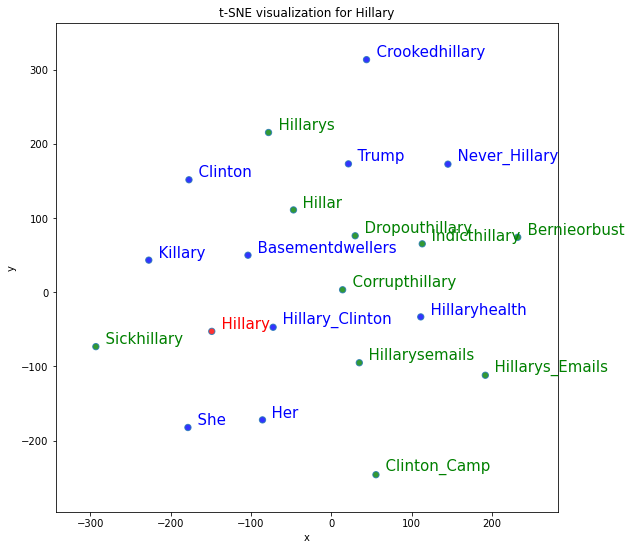

In [27]:
tsnescatterplot(w2v_model, "hillary", 
                [t[0] for t in w2v_model.wv.most_similar(positive=["hillary"], topn=20)][10:])

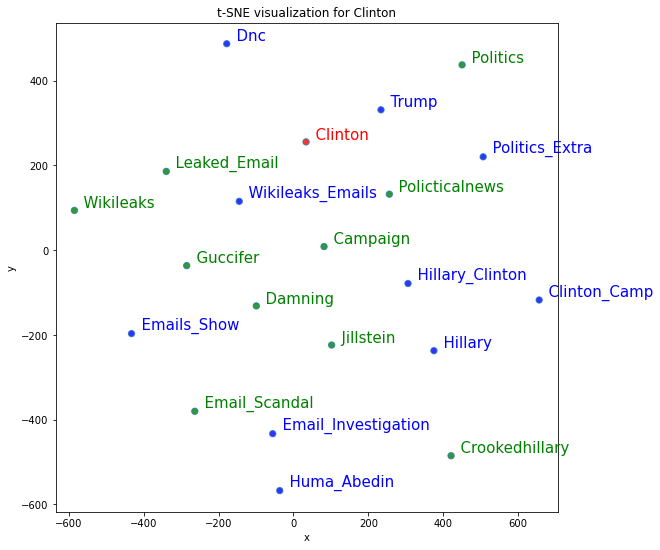

In [28]:
tsnescatterplot(w2v_model, "clinton", 
                [t[0] for t in w2v_model.wv.most_similar(positive=["clinton"], topn=20)][10:])

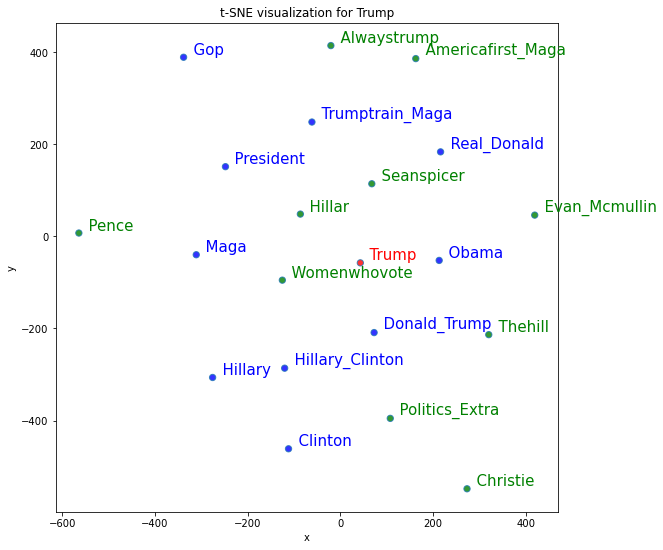

In [29]:
tsnescatterplot(w2v_model, "trump", 
                [t[0] for t in w2v_model.wv.most_similar(positive=["trump"], topn=20)][10:])

## Saving the model

No more training - using `init_sims()` to make the model more memory efficient

In [30]:
w2v_model.init_sims(replace=True)

INFO - 12:41:14: precomputing L2-norms of word weight vectors


In [31]:
w2v_model.save("w2v.model")

INFO - 12:41:15: saving Word2Vec object under w2v.model, separately None
INFO - 12:41:15: not storing attribute vectors_norm
INFO - 12:41:15: not storing attribute cum_table
INFO - 12:41:16: saved w2v.model
